<a href="https://colab.research.google.com/github/nicolekiamichi/college-football-playoff-predictions/blob/main/college_football_playoff_predictions_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement
The College Football Playoff (CFP) is the annual tournament for the National Collegiate Athletic Association (NCAA) Division I Football Bowl Subdivision (FBS), which is the highest level of college football competition in the United States. In the College Football Playoff tournament, the top four teams from the regular season play in two semifinal games, with the winner of each semifinal advancing to the final National Championship game. The CFP tournament was introduced in 2014 and has continued annually ever since.

Not surprisingly, it is the goal of most college football teams to make it to the CFP tournament and have a shot at becoming National Champions. The goal of this project is to be able to predict which teams will finish the college football season ranked in the top four (i.e. invited to the CFP tournament). Similarly, this project aims to identify the features that have the most impact on a team finishing the season ranked in the top four.

This project is important because it could help coaches and players break down their overarching goal of attending the CFP tournament into smaller, more actionable goals to strive for during the season or in pre-season training. The results of this project could also be useful to someone who participates in sports betting and wants to place money on a team part-way through the season.

# Data Sources
The [College Football Team Stats Seasons 2013 to 2020](https://www.kaggle.com/jeffgallini/college-football-team-stats-2019) data set from Kaggle was the first data set used in this analysis. The data set consisted of team statistics for each FBS-level college football team from the years 2013 to 2020 in the form of 8 separate CSV files (1 for each season). After merging all seasons, the final data set from Kaggle contained 970 rows and 146 columns. Subsequently, certain fields were manually calculated from existing fields in the data, such as each team's win percentage (win percentage = number of wins/number of games).

One feature that the Kaggle data set did not contain that research indicated would be an important factor in predicting a team's final rank was a "strength of schedule" variable. Data was scraped from the [Team Rankings website](https://www.teamrankings.com/college-football/ranking/schedule-strength-by-other) and merged into the original Kaggle data set in the form of one column indicating each team's strength of schedule for each year.

Finally, the target variable used in this analysis was added manually as a binary variable to denote whether or not a team finished the season ranked in the top four. This data was obtained from the [College Poll Archive website](http://www.collegepollarchive.com/football/ap/seasons.cfm?seasonid=2014#.YbjhB73MJPY). The final merged, cleaned, and wrangled data set contained 843 rows and 148 columns. More information on data wrangling can be found in the methodology section.

# Methodology
## Import Modules and Data

In [1]:
# import modules
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import warnings
from google.colab import data_table

warnings.filterwarnings('ignore')
data_table.disable_dataframe_formatter()

# authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# function to read CSV files from Google drive
def read_csv_from_drive(link, file_name):
  id = link.split("/")[-2]
  downloaded = drive.CreateFile({'id':id})
  downloaded.GetContentFile(file_name)
  data = pd.read_csv(file_name)
  return data

# import data
data13 = read_csv_from_drive('https://drive.google.com/file/d/1jtwrJYz0wjOWrVMIUL6XCNunYao2YWgy/view?usp=drive_link', 'cfb13.csv')
data14 = read_csv_from_drive('https://drive.google.com/file/d/1xdNhCBG33ZjBqZ_HQxfbt4RfoG3hJFrz/view?usp=drive_link', 'cfb14.csv')
data15 = read_csv_from_drive('https://drive.google.com/file/d/1Nk_o3ZatTWuNQh83v4QDulSMjN7gEgaS/view?usp=drive_link', 'cfb15.csv')
data16 = read_csv_from_drive('https://drive.google.com/file/d/1Wx3sfiVdRYgy-ocgLoN-94gnB7VqYleo/view?usp=drive_link', 'cfb16.csv')
data17 = read_csv_from_drive('https://drive.google.com/file/d/1x2AE16NJfGJB7HC2kFQOQzkkCecskfG6/view?usp=drive_link', 'cfb17.csv')
data18 = read_csv_from_drive('https://drive.google.com/file/d/1WOhVg0qF0EgGKzjrG0SvzUgvr7L7ocQ3/view?usp=drive_link', 'cfb18.csv')
data19 = read_csv_from_drive('https://drive.google.com/file/d/17-0516pkH-bstR0RG5VIEUkAIRJ99whU/view?usp=drive_link', 'cfb19.csv')
data20 = read_csv_from_drive('https://drive.google.com/file/d/1diN74kG5ULmsBfnhD3Hgz4pfGvP_6e71/view?usp=drive_link', 'cfb20.csv')

## Data cleaning

The first step in data cleaning was to find all of the similar columns between the 8 CSV files from the Kaggle data set and remove any columns that did not exist in every file. Then, a *year* variable was added to each data set to ensure that the data could be properly split for training and testing. At this point in data cleaning, all 8 CSV files were merged into one data set.

In [2]:
# find column differences in all data frames
cols1 = list(data13.columns)
cols2 = list(data19.columns)
diff1 = set(cols1).difference(set(cols2))
diff2 = set(cols2).difference(set(cols1))

# update columns to make all columns match
# 'Total.TDs' - remove, use 'Off.TDs' instead
data13 = data13.drop('Total.TDs', axis=1)
data14 = data14.drop('Total.TDs', axis=1)
data15 = data15.drop('Total.TDs', axis=1)
# diff2 - remove, don't exist in other data sets
drops = ['...40', 'Opponent.Kickoff.Return.Yards', 'Kickoff.Touchbacks', 'Kickoff.Return.Def.Rank',
         'Opp.Kickoff.Return.Touchdowns.Allowed', 'Avg.Yards.per.Kickoff.Return.Allowed', 'Opp.Kickoff.Returns']
data16 = data16.drop(drops, axis=1)
data17 = data17.drop(drops, axis=1)
data18 = data18.drop(drops, axis=1)
data19 = data19.drop(drops, axis=1)
data20 = data20.drop(drops, axis=1)

# re-check column differences in all data frames
cols1 = list(data13.columns)
cols2 = list(data19.columns)
diff1 = set(cols1).difference(set(cols2))
diff2 = set(cols2).difference(set(cols1))

# add year to all data frames
data13['Year'] = 2013
data14['Year'] = 2014
data15['Year'] = 2015
data16['Year'] = 2016
data17['Year'] = 2017
data18['Year'] = 2018
data19['Year'] = 2019
data20['Year'] = 2020

# combine all data
data = pd.concat([data13, data14, data15, data16, data17, data18, data19, data20])

Next, certain data inconsistencies were corrected, such as adding missing conferences and removing parentheses from team names. The *team-conference* column was split into two separate columns. The target variable, *finished_top_four*, was added manually as a binary variable to denote whether a team finished the season ranked in the top four teams or not. A column to denote each team's win percentage, *win_pct*, was added as a calculated field based on the *wins* and *games* columns.

In [3]:
# fix missing conferences
data = data.rename(columns={'Team': 'Team-Conf'})
data.loc[data['Team-Conf'] == 'Ole Miss ()', 'Team-Conf'] = 'Ole Miss (SEC)'
data.loc[data['Team-Conf'] == 'Pittsburgh ()', 'Team-Conf'] = 'Pittsburgh (ACC)'
data.loc[data['Team-Conf'] == 'Miami (OH) (MAC)', 'Team-Conf'] = 'Miami OH (MAC)'
data.loc[data['Team-Conf'] == 'Miami (FL) (ACC)', 'Team-Conf'] = 'Miami FL (ACC)'

# expand 'Team-Conference' columns
data[['Team', 'conf_REMOVE']] = data['Team-Conf'].str.split('(', expand=True)
data[['Conference', 'REMOVE']] = data['conf_REMOVE'].str.split(')', expand=True)
data = data.drop(['conf_REMOVE', 'REMOVE'], axis=1)
data['Team'] = data['Team'].str.strip()

# check that all columns are numeric
non_numeric = data[~data.applymap(np.isreal)].dropna(axis=1)
# update time of possession columns to numeric types
data['Time.of.Possession'] = data['Time.of.Possession'].str.replace(':', '.').str.split('\xa0\xa0\xa0', expand=True)[1].astype(float)
data['Average.Time.of.Possession.per.Game'] = data['Average.Time.of.Possession.per.Game'].str.replace(':', '.').str.split('\xa0\xa0\xa0', expand=True)[1].astype(float)

# add first target variable
data['won_championship'] = 0
data.loc[(data.Year == 2013) & (data.Team == 'Florida St.'), 'won_championship'] = 1
data.loc[(data.Year == 2014) & (data.Team == 'Ohio St.'), 'won_championship'] = 1
data.loc[(data.Year == 2015) & (data.Team == 'Alabama'), 'won_championship'] = 1
data.loc[(data.Year == 2016) & (data.Team == 'Clemson'), 'won_championship'] = 1
data.loc[(data.Year == 2017) & (data.Team == 'Alabama'), 'won_championship'] = 1
data.loc[(data.Year == 2018) & (data.Team == 'Clemson'), 'won_championship'] = 1
data.loc[(data.Year == 2019) & (data.Team == 'LSU'), 'won_championship'] = 1
data.loc[(data.Year == 2020) & (data.Team == 'Alabama'), 'won_championship'] = 1

# add second target variable (using AP Poll)
data['finished_top_four'] = 0
data.loc[(data.Year == 2013) & (data['Team'].isin(['Florida St.', 'Auburn', 'Michigan St.', 'South Carolina'])), 'finished_top_four'] = 1
data.loc[(data.Year == 2014) & (data['Team'].isin(['Ohio St.', 'Oregon', 'TCU', 'Alabama'])), 'finished_top_four'] = 1
data.loc[(data.Year == 2015) & (data['Team'].isin(['Alabama', 'Clemson', 'Stanford', 'Ohio St.'])), 'finished_top_four'] = 1
data.loc[(data.Year == 2016) & (data['Team'].isin(['Clemson', 'Alabama', 'USC', 'Washington'])), 'finished_top_four'] = 1
data.loc[(data.Year == 2017) & (data['Team'].isin(['Alabama', 'Georgia', 'Oklahoma', 'Clemson'])), 'finished_top_four'] = 1
data.loc[(data.Year == 2018) & (data['Team'].isin(['Clemson', 'Alabama', 'Ohio St.', 'Oklahoma'])), 'finished_top_four'] = 1
data.loc[(data.Year == 2019) & (data['Team'].isin(['LSU', 'Clemson', 'Ohio St.', 'Georgia'])), 'finished_top_four'] = 1
data.loc[(data.Year == 2020) & (data['Team'].isin(['Alabama', 'Clemson', 'Ohio St.', 'Notre Dame'])), 'finished_top_four'] = 1

# add calculated field
data['Win.Pct'] = data['Win'] / data['Games']

# move new columns to beginning
extra_cols = 3
cols = data.columns.tolist()
cols = cols[-(extra_cols + 3):] + cols[:-(extra_cols + 3)]
data = data[cols]

Then, the columns in the data were manually and thoroughly searched for any variables that needed to be controlled for by the number of games that each team had played in the season, since not every team played the same number of games within each season. In this extensive search, 89 variables were identified as needing to be controlled by the number of games played. Examples of these features include *total_offensive_yards*, *total_touchdowns_allowed*, and *net_punt_return_yards*. Since these variables were simply count variables over the entire season, it was important to control for them. Upon dividing each column by the number of games, the names of each column were also updated to include a *per_game* notation.

In [4]:
# control for number of games played since each team played a different number of games each season
control_vars = ['Off.Plays', 'Off.Yards', 'Off.TDs', 'Def.Plays', 'Yards.Allowed', 'Off.TDs.Allowed',
                'Total.TDs.Allowed', 'First.Down.Runs', 'First.Down.Passes', 'First.Down.Penalties', 'First.Downs',
                'Opp.First.Down.Runs', 'Opp.First.Down.Passes', 'Opp.First.Down.Penalties', 'Opp.First.Downs',
                'X4th.Attempts', 'X4th.Conversions', 'Opp.4th.Conversion', 'Opp.4th.Attempt',
                'Kickoffs.Returned', 'Kickoff.Return.Yards', 'Kickoff.Return.Touchdowns', 'Pass.Attempts',
                'Pass.Completions', 'Interceptions.Thrown.x', 'Pass.Yards', 'Pass.Yards.Attempt', 'Yards.Completion',
                'Pass.Touchdowns', 'Opp.Completions.Allowed', 'Penalties', 'Penalty.Yards', 'Punt.Returns',
                'Net.Punt.Return.Yards', 'Punt.Return.Touchdowns', 'Opp.Punt.Returns', 'Opp.Net.Punt.Return.Yards',
                'Opp.Punt.Return.Touchdowns.Allowed', 'Redzone.Attempts', 'Redzone.Rush.TD', 'Redzone.Pass.TD',
                'Redzone.Field.Goals.Made', 'Redzone.Scores', 'Opp.Redzone.Attempts', 'Opp.Redzone.Rush.TD.Allowed',
                'Opp.Redzone.Pass.Touchdowns.Allowed', 'Opp.Redzone.Field.Goals.Made', 'Opp.Redzone.Scores',
                'Rush.Attempts', 'Rush.Yds', 'Rushing.TD', 'Opp.Rush.Attempts', 'Opp.Rush.Yards.Alloweed',
                'Opp.Rush.Touchdowns.Allowed', 'Sacks', 'Sack.Yards', 'Touchdowns.Allowed', 'Opponent.Extra.Points',
                'X2.Point.Conversions.Allowed', 'Opp.Deflected.Extra.Points', 'Opp.Feild.Goals.Made', 'Opp.Safety',
                'Points.Allowed', 'Touchdowns', 'PAT', 'X2.Point.Conversions', 'Defensive.Points', 'Feild.Goals',
                'Safety', 'Total.Points', 'Solo.Tackle.For.Loss', 'Assist.Tackle.For.Loss', 'Tackle.for.Loss.Yards',
                'Total.Tackle.For.Loss', 'X3rd.Attempts', 'X3rd.Conversions', 'Opp.3rd.Conversion', 'Opp.3rd.Attempt',
                'Time.of.Possession', 'Fumbles.Recovered', 'Opponents.Intercepted', 'Turnovers.Gain', 'Fumbles.Lost',
                'Interceptions.Thrown.y', 'Turnovers.Lost', 'Turnover.Margin', 'Opp.Pass.Attempts',
                'Opp.Pass.Yds.Allowed', 'Opp.Pass.TDs.Allowed']
# divide by number of games
data.loc[:, control_vars] = data.loc[:, control_vars].div(data.Games, axis=0).astype(float)
# add '.PER.GAME' to each column name
data = data.rename(columns={col: col + '.PER.GAME' for col in data.columns if col in control_vars})

Finally, any duplicate columns (via name or value) were dropped from the data, and the data types of each column were updated to match their values. The *conference* column was one-hot encoded to be used for modeling. The *strength_of_schedule* column was merged into the full data set by the *team* and *year* columns. Data from the year 2020 was excluded from the final data set since that season was cut short for certain teams and heavily-impacted by the COVID-19 pandemic. The final wrangled data set contained 843 rows and 148 columns.

In [5]:
# remove duplicate columns (values)
data = data.T.drop_duplicates().T
# remove duplicate columns (names & close - but not exact - values)
data = data.drop(['Off.Yards.per.Game', 'Pass.Yards.Per.Game', 'Penalty.Yards.Per.Game', 'Avg.Points.per.Game.Allowed', 'Points.Per.Game'], axis=1)

# one-hot encode conference
values = np.array(data['Conference'])
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
onehot_encoder = OneHotEncoder(sparse = False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
ohe = pd.DataFrame(onehot_encoded)
ohe_columns = [string.replace(' ','.') for string in np.unique(data['Conference'])]
ohe.columns = ohe_columns
temp = pd.concat([data, ohe.reindex(data.index)], axis = 1)
temp = temp.rename(columns = {col: col + '.CONFERENCE' for col in temp.columns if col in ohe_columns})
data = temp

# update column name format
data.columns = [string.replace('.', '_').replace('Feild', 'Field').lower() for string in data.columns]

# update column data types
data[['year','won_championship','finished_top_four','win_pct']] = data[['year','won_championship','finished_top_four','win_pct']].astype(float)
data[['team','conference','team-conf']] = data[['team','conference','team-conf']].astype(str)
data.iloc[:,(extra_cols + 4):len(data.columns)] = data.iloc[:,(extra_cols + 4):len(data.columns)].astype(float)

# exclude 2020 because of COVID-19 pandemic
data = data.loc[data['year'] != 2020]

# add strength of schedule variable
strength = read_csv_from_drive('https://drive.google.com/file/d/1PEsc39IV13bx-wQbX1Uae_LMjeLHwLuf/view?usp=drive_link', 'strength_of_schedule.csv')
data = data.merge(strength, on=['year', 'team'])

This final data was then split into training and test sets, where the training data included rows of years 2013 - 2018, and the test data included rows of year 2019. In both data sets, columns *year*, *team*, *conference*, *won_championship*, *finished_top_four* (target variable), *team_conference*, *games*, *win*, and *loss* were dropped since they did not have the potential to add explanatory power to the models (note that the *conference* variable's information was still included the final modeling data since it was one-hot encoded earlier, and that information on *games*, *wins*, and *losses* was included in the calculated *win_pct* variable that was also included in the final modeling data). The final training data had 713 rows (\~85%) and 139 columns, while the final test data had 130 rows (\~15%) and 139 columns.

In [6]:
# define training and test data sets
train = data.loc[data['year'].isin([2013, 2014, 2015, 2016, 2017, 2018])]
X_train_unscaled = train.iloc[:, np.r_[np.where(train.columns == 'win_pct')[0][0], (extra_cols + 7):len(train.columns)]]
y_train = train['finished_top_four']

test = data[data['year'] == 2019]
X_test_unscaled = test.iloc[:, np.r_[np.where(test.columns == 'win_pct')[0][0], (extra_cols + 7):len(test.columns)]]
y_test = test['finished_top_four']

## Feature selection

Feature selection was applied to the training data to determine the most important and explanatory of the 139 possible features. A [combined method](https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2) of multiple variable selection techniques was taken to attempt to reduce the number of features to be modeled. These variable selection techniques included:

1.  Pearson correlation selection

2.  Chi-squared selection

3.  Recursive feature elimination

4.  L2 penalty selection

5.  Random forest-based selection

6.  XGBoost-based selection.

In [7]:
# Pearson correlation selector
def pearson_corr_selector(X, y, num_features):
    cor_list = []
    feature_names = X.columns.tolist()
    # calculate the correlation with y for each feature
    for col in X.columns.tolist():
      cor = np.corrcoef(X[col], y)[1, 0]
      cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(cor) else cor for cor in cor_list]
    # get feature names
    selected_feature_names = X.iloc[:, np.argsort(np.abs(cor_list))[-num_features:]].columns.tolist()
    # feature selection: 0 for not select, 1 for select
    selection = [True if feat in selected_feature_names else False for feat in feature_names]
    return selection

num_feats = 10
pearson_corr_support = pearson_corr_selector(X_train_unscaled, y_train, num_feats)

# Chi-squared selector
X_norm = MinMaxScaler().fit_transform(X_train_unscaled)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y_train)
chi_support = chi_selector.get_support()
chi_feature = X_train_unscaled.loc[:, chi_support].columns.tolist()

# Recursive feature elimination
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y_train)
rfe_support = rfe_selector.get_support()
rfe_feature = X_train_unscaled.loc[:, rfe_support].columns.tolist()

# L2 penalty selector
embedded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
embedded_lr_selector.fit(X_norm, y_train)
embedded_lr_support = embedded_lr_selector.get_support()
embedded_lr_feature = X_train_unscaled.loc[:, embedded_lr_support].columns.tolist()

# Random forest-based selector
embedded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embedded_rf_selector.fit(X_train_unscaled, y_train)
embedded_rf_support = embedded_rf_selector.get_support()
embedded_rf_feature = X_train_unscaled.loc[:, embedded_rf_support].columns.tolist()

# XGBoost selector
xgboost = XGBClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                        reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
embedded_xgb_selector = SelectFromModel(xgboost, max_features=num_feats)
embedded_xgb_selector.fit(X_train_unscaled, y_train)
embedded_xgb_support = embedded_xgb_selector.get_support()
embedded_xgb_feature = X_train_unscaled.loc[:, embedded_xgb_support].columns.tolist()

# combine all selectors
feature_name = X_train_unscaled.columns.tolist()
feature_selection_df = pd.DataFrame(
    {'Feature': feature_name, 'Pearson': pearson_corr_support, 'Chi-2': chi_support, 'RFE': rfe_support,
     'L2 Penalty': embedded_lr_support, 'Random Forest': embedded_rf_support, 'XGBoost': embedded_xgb_support})
feature_selection_df['Total'] = feature_selection_df.drop('Feature', axis=1).sum(axis=1)
feature_selection_df = feature_selection_df.sort_values(['Total', 'Feature'], ascending=False).reset_index(drop=True)
selected_feats = feature_selection_df.loc[feature_selection_df['Total'] != 0, 'Feature']
feature_selection_df[:5]

Fitting estimator with 139 features.
Fitting estimator with 129 features.
Fitting estimator with 119 features.
Fitting estimator with 109 features.
Fitting estimator with 99 features.
Fitting estimator with 89 features.
Fitting estimator with 79 features.
Fitting estimator with 69 features.
Fitting estimator with 59 features.
Fitting estimator with 49 features.
Fitting estimator with 39 features.
Fitting estimator with 29 features.
Fitting estimator with 19 features.


,Feature,Pearson,Chi-2,RFE,L2 Penalty,Random Forest,XGBoost,Total
0,win_pct,True,True,True,True,True,False,5
1,strength_of_schedule,True,True,True,True,True,False,5
2,pat_per_game,True,True,True,False,False,True,4
3,off_yards_play,True,False,True,True,True,False,4
4,scoring_off_rank,True,True,True,False,False,False,3


A combined total of 25 variables that contained explanatory power for predicting whether a team would finish a season ranked in the top four were selected by these techniques.

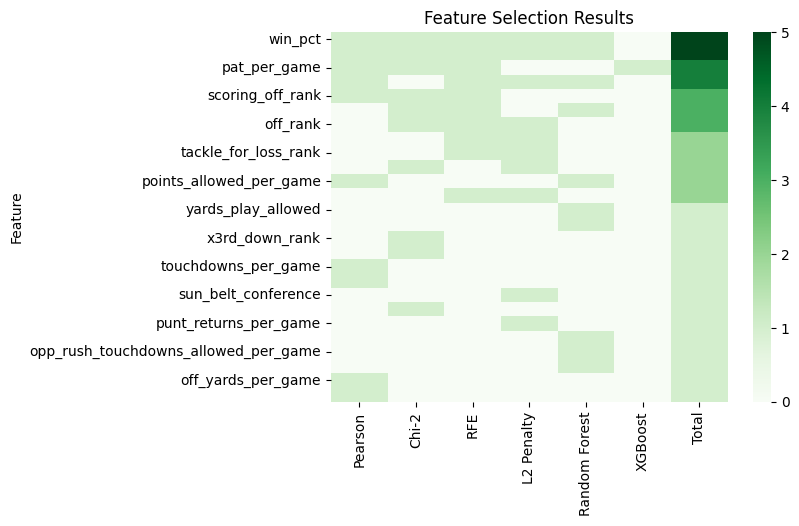

In [8]:
# show feature selections
feature_selections = feature_selection_df[feature_selection_df['Total'] != 0]
feature_selections.iloc[:, 1:] = feature_selections.iloc[:, 1:].astype(float)
new = feature_selections.set_index('Feature')
plt.figure()
sns.heatmap(new, cmap='Greens')
plt.title('Feature Selection Results')
plt.show()

To determine whether these 25 selected variables were appropriate for modeling, a correlation heatmap between all 25 variables was computed to check for potential collinearity.

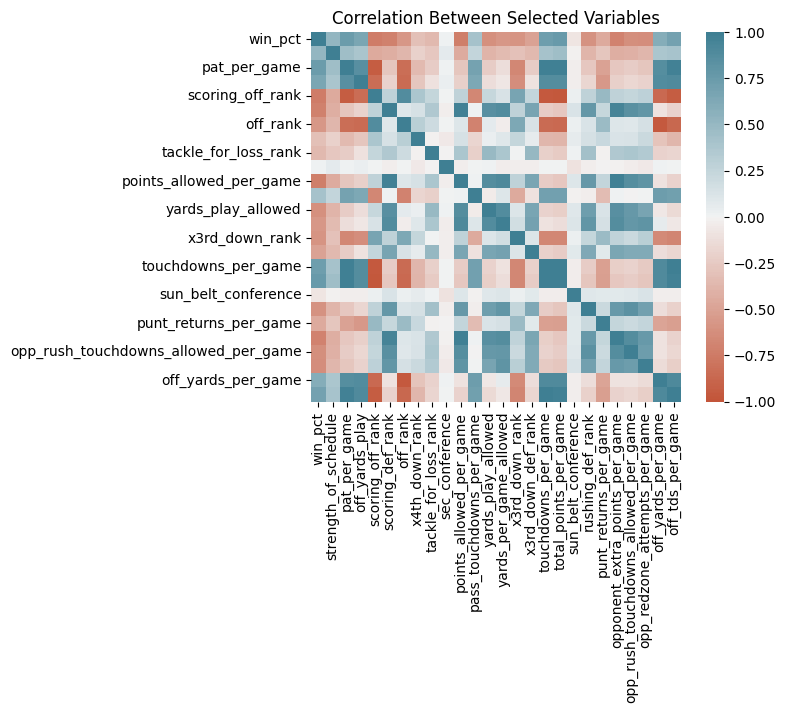

In [9]:
# visualize selected features
corr_df = train[selected_feats].corr()
plt.figure()
sns.heatmap(corr_df, cmap=sns.diverging_palette(20, 220, n=200), vmin=-1, vmax=1, center=0, square=True)
plt.title('Correlation Between Selected Variables')
plt.show()

As the heatmap shows, many of the top-selected variables are highly-correlated with one another, which would violate certain assumptions of many model types. Based on this information, it was decided to perform dimensionality reduction on the data to reduce collinearity in the predictors and extract the most important features from the data while simultaneously avoiding feature correlation.

## Dimensionality Reduction

Principal component analysis (PCA) is a dimensionality reduction technique that creates new, uncorrelated variables from the original data features by computing the eigenvectors and eigenvalues of the covariance matrix. In this project, the training data was standardized and PCA was applied. The total number of principal components was plotted against the cumulative explained variance to determine how many principal components were required to explain 95% of the total variance.

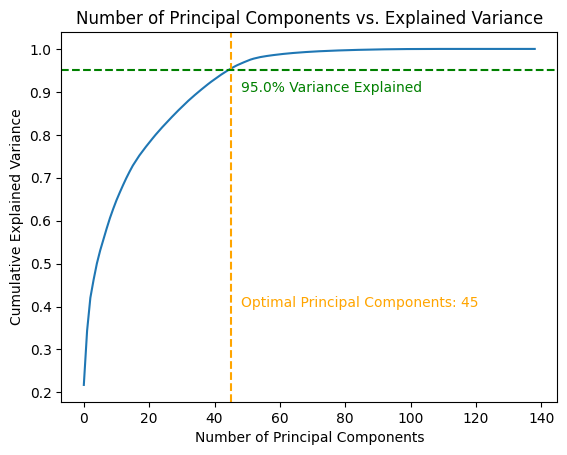

In [10]:
# standardize the data
X_train = StandardScaler().fit_transform(X_train_unscaled)
X_test = StandardScaler().fit_transform(X_test_unscaled)

# determine number of principal components needed to explain 95% of the variance
variance_explained = 0.95
pca = PCA(random_state=100)
pca.fit(X_train)
explained_variance = np.cumsum(pca.explained_variance_ratio_)
opt_components = len(np.where(explained_variance < variance_explained)[0])
plt.figure()
plt.title('Number of Principal Components vs. Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.plot(explained_variance)
plt.axvline(opt_components, color='orange', linestyle='dashed')
plt.text(x=opt_components + 3, y=0.4, s="Optimal Principal Components: " + str(opt_components), color='orange')
plt.axhline(variance_explained, color='green', linestyle='dashed')
plt.text(x=opt_components + 3, y=0.9, s=str(round(variance_explained * 100, 0)) + "% Variance Explained", color='green')
plt.show()

In total, 45 principle components explained 95% of the variance. A correlation heatmap between all principle components was computed to check once again for potential collinearity. As expected, the principle components were almost perfectly uncorrelated, suggesting that they are viable model-building predictors.

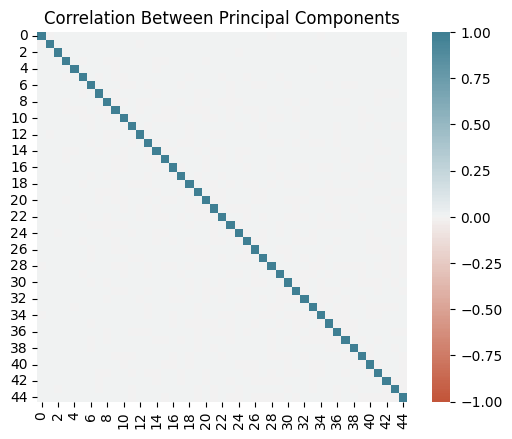

In [11]:
# get train PCA data
pca_model = PCA(n_components=opt_components, random_state=100)
X_train_pca = pca_model.fit_transform(X_train)

# get test PCA data
X_test_pca = pca_model.transform(X_test)

# verify that principal components are uncorrelated
plt.figure()
sns.heatmap(np.corrcoef(X_train_pca.transpose()), cmap=sns.diverging_palette(20, 220, n=200), vmin=-1, vmax=1, center=0, square=True)
plt.title('Correlation Between Principal Components')
plt.show()

## Model Training and Cross-Validation

To accurately predict whether a college football team would finish ranked in the top four teams, many model types were considered, including:

1.  Logistic regression classification

2.  Naive Bayes classification

3.  K-nearest neighbors (KNN) classification

4.  Decision tree classification

5.  Random forest classification

6.  Neural network classification.

Each model was built and trained on the training data set, with parameters for KNN, decision tree, random forest, and neural network models selected via 5-fold cross-validation. Once the models were trained, their performance was also evaluated via 5-fold cross-validation.

In [12]:
# set up 10-fold cross validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=100)

# logistic regression
logit_model = LogisticRegression(max_iter=200, solver='liblinear').fit(X_train_pca, y_train)
logit_score = np.mean(cross_val_score(logit_model, X_train_pca, y_train, cv=k_fold, n_jobs=1))

# naive bayes
naive_bayes_model = GaussianNB().fit(X_train_pca, y_train)
naive_bayes_score = np.mean(cross_val_score(naive_bayes_model, X_train_pca, y_train, cv=k_fold, n_jobs=1))

# k-nearest neighbors
param_grid = {"n_neighbors": np.arange(1, 25)}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5).fit(X_train_pca, y_train)
knn_model = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors']).fit(X_train_pca, y_train)
knn_score = np.mean(cross_val_score(knn_model, X_train_pca, y_train, cv=k_fold, n_jobs=1))

# decision tree
param_grid = {"criterion": ['gini', 'entropy'], "max_depth": [1, 10, 100]}
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5).fit(X_train_pca, y_train)
decision_tree_model = DecisionTreeClassifier(criterion=grid_search.best_params_['criterion'],
                                             max_depth=grid_search.best_params_['max_depth']).fit(X_train_pca, y_train)
decision_tree_score = np.mean(cross_val_score(decision_tree_model, X_train_pca, y_train, cv=k_fold, n_jobs=1))

# random forest
param_grid = {"n_estimators": [10, 100, 1000], "max_depth": [1, 10, 100]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5).fit(X_train_pca, y_train)
random_forest_model = RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'],
                                             max_depth=grid_search.best_params_['max_depth']).fit(X_train_pca, y_train)
random_forest_score = np.mean(cross_val_score(random_forest_model, X_train_pca, y_train, cv=k_fold, n_jobs=1))

# neural network
param_grid = {"max_iter": [2000], "hidden_layer_sizes": np.arange(1, 10)}
grid_search = GridSearchCV(MLPClassifier(), param_grid, cv=5).fit(X_train_pca, y_train)
neural_network_model = MLPClassifier(hidden_layer_sizes=grid_search.best_params_['hidden_layer_sizes'],
                                     max_iter=grid_search.best_params_['max_iter']).fit(X_train_pca, y_train)
neural_network_score = np.mean(cross_val_score(neural_network_model, X_train_pca, y_train, cv=k_fold, n_jobs=1))

Results of model training and performance evaluation are below.

In [13]:
# results
results = pd.DataFrame(
    {'Classifier': ['Logistic Regression', 'Naive Bayes', 'KNN', 'Decision Tree', 'Random Forest', 'Neural Network'],
     'Accuracy': [logit_score, naive_bayes_score, knn_score, decision_tree_score, random_forest_score, neural_network_score]}
    )
results

,Classifier,Accuracy
0,Logistic Regression,0.962149
1,Naive Bayes,0.963567
2,KNN,0.973367
3,Decision Tree,0.964956
4,Random Forest,0.967773
5,Neural Network,0.959342


## Final Model

Since the k-nearest neighbors model had the highest cross-validated accuracy of all trained models, it was selected as the final model to be used to predict the test data. The KNN model had a cross-validated number of nearest neighbors equal to 4, meaning that it would classify each data point as the most common class of its four nearest neighbors, using the 45 principle components as input.

# Model Evaluation
## Model Predictions

The final KNN model was run on the test data, which included all data from the 2019 college football season. Results of the KNN model predictions on the test data, ordered by the model's predicted probability of a team finishing in the top four, are below. Note that the remaining 117 teams in the test data set had a predicted probability of finishing in the top four teams of 0, and therefore were excluded from the table.

In [14]:
# use k-nearest neighbors model as final model to get 2019 predictions
y_pred = pd.concat([test['team'].reset_index(drop=True),
                    pd.DataFrame(y_test).reset_index(drop=True),
                    pd.DataFrame(knn_model.predict_proba(X_test_pca)).iloc[:, [1]]],
                   axis=1)
y_pred.columns = ['team', 'finished_top_four', 'knn_pred']
y_pred.loc[y_pred['knn_pred'] != 0].sort_values(by=['finished_top_four', 'knn_pred'], ascending=False).reset_index(drop=True)

,team,finished_top_four,knn_pred
0,Clemson,1.0,1.00
1,Georgia,1.0,0.75
2,LSU,1.0,0.75
3,Ohio St.,1.0,0.50
4,Alabama,0.0,0.50
5,Oklahoma,0.0,0.50
6,Florida,0.0,0.25
7,Louisiana,0.0,0.25
8,Minnesota,0.0,0.25
9,Notre Dame,0.0,0.25


## Evaluation Metrics

To fully evaluate the final model, the KNN predicted probabilities were transformed into a binary variable. A cutoff threshold value of 0.4 for the KNN predictions that optimized accuracy, sensitivity, and specificity was selected via the plot below.

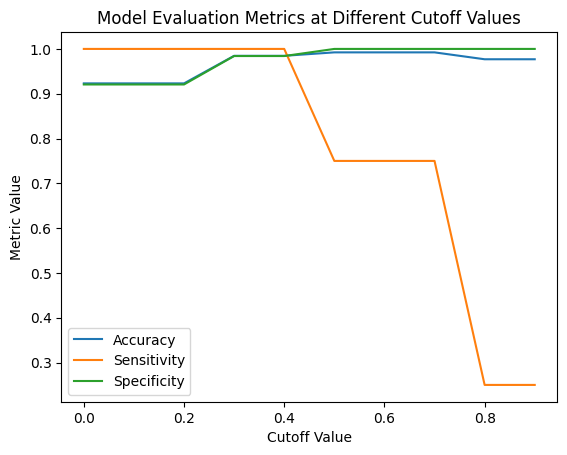

In [15]:
# Create columns with different probability cutoffs
prob_cutoffs = [float(x) / 10 for x in range(10)]
for i in prob_cutoffs:
    y_pred[i] = y_pred.knn_pred.map(lambda x: 1 if x > i else 0)

# calculate accuracy, sensitivity & specificity for different cut off points
Probability = pd.DataFrame(columns=['Probability', 'Accuracy', 'Sensitivity', 'Specificity'])
Total = None
for i in prob_cutoffs:
    CM = confusion_matrix(y_pred.finished_top_four, y_pred[i])
    Total = sum(sum(CM))
    Accuracy = (CM[0, 0] + CM[1, 1]) / Total
    Sensitivity = CM[1, 1] / (CM[1, 1] + CM[1, 0])
    Specificity = CM[0, 0] / (CM[0, 0] + CM[0, 1])
    Probability.loc[i] = [i, Accuracy, Sensitivity, Specificity]
Probability.plot.line(x='Probability', y=['Accuracy', 'Sensitivity', 'Specificity'])
plt.title('Model Evaluation Metrics at Different Cutoff Values')
plt.xlabel('Cutoff Value')
plt.ylabel('Metric Value')
plt.show()

The cutoff value of 0.4 yielded the following confusion matrix and resulting model performance metrics. In total, final testing model accuracy was even higher than the cross-validated training accuracy, indicating that the model has strong predictive power.

In [16]:
# calculate evaluation metrics
CM = confusion_matrix(y_pred.finished_top_four, y_pred[0.4])
Accuracy = (CM[0, 0] + CM[1, 1]) / Total
Sensitivity = CM[1, 1] / (CM[1, 1] + CM[1, 0])
Specificity = CM[0, 0] / (CM[0, 0] + CM[0, 1])
conf_matrix = pd.DataFrame(CM)
conf_matrix

,0,1
0,124,2
1,0,4


In [17]:
perf_metrics = pd.DataFrame({'Performance Metric': ['Accuracy', 'Sensitivity', 'Specificity'], 'Value': [Accuracy, Sensitivity, Specificity]})
perf_metrics

,Performance Metric,Value
0,Accuracy,0.984615
1,Sensitivity,1.000000
2,Specificity,0.984127


# Final Results
## Prediction Results

The final model correctly predicted the top four teams of the 2019 college football season and had a very high testing accuracy. Although two teams were incorrectly predicted to finish in the top four via the 0.4 cutoff threshold (Oklahoma and Alabama), these teams ended the season ranked 7th and 8th, respectively, proving that the model was not far off in classifying them as top four finishers. It's clear that this model would be useful to anyone looking to predict the outcome of a college football season.

## Feature Importance Results

Apart from simply being able to predict whether a team will finish at the top, it was important to determine which factors most heavily influenced this outcome. To interpret feature important results, the principal components were mapped back to the original input variables and correlations between the original data and the principal components were computed.

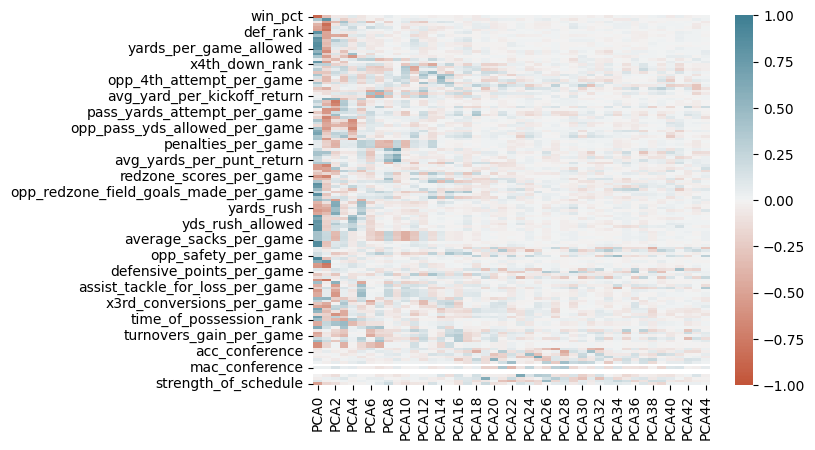

In [18]:
X_train_pca_temp = X_train_pca.copy()
X_train_pca_temp = pd.DataFrame(X_train_pca_temp)
X_train_pca_temp.columns = X_train_pca_temp.columns.map(str)
X_train_pca_temp = X_train_pca_temp.rename(columns={col: 'PCA' + col for col in X_train_pca_temp.columns})

temp = pd.concat([X_train_pca_temp, X_train_unscaled], axis=1)
remapped = temp[temp.columns[0:]].corr()[X_train_pca_temp.columns][:]
remapped = remapped.iloc[len(X_train_pca_temp.columns):len(remapped), :]

sns.heatmap(remapped, cmap=sns.diverging_palette(20, 220, n=200), vmin=-1, vmax=1, center=0)
plt.show()

The most-highly correlated original variables for the top five principle components are displayed below. The results of this analysis are extremely important. The first principal component is strongly correlated with the original variables *points_allowed_per_game*, *scoring_def_rank*, *total_tds_allowed_per_game*, *opponent_extra_points_per_game*, and *win_pct*. This indicates that these variables vary together. Given what these variables represent, principal component 1 can be viewed as a measure of a team's defense. This would indicate that the overall most important feature a college football team can have if it wants to finish ranked in the top four is its defense.

In [24]:
# PC0: measure of team's defense
pc0 = pd.DataFrame(remapped.iloc[:, 0])
pc0_sorted = pc0.iloc[(-pc0['PCA0'].abs()).argsort()][:5]
pc0_sorted

,PCA0
points_allowed_per_game,0.903792
scoring_def_rank,0.888738
total_tds_allowed_per_game,0.879973
opponent_extra_points_per_game,0.878019
win_pct,-0.868222


In [29]:
# PC1: measure of team's offense
pc1 = pd.DataFrame(remapped.iloc[:, 1])
pc1_sorted = pc1.iloc[(-pc1['PCA1'].abs()).argsort()][:5]
pc1_sorted

,PCA1
off_yards_per_game,-0.837524
off_rank,0.809255
off_tds_per_game,-0.798970
touchdowns_per_game,-0.779139
total_points_per_game,-0.773287


In [26]:
# PC2: measure of team's balance between rushing and passing
pc2 = pd.DataFrame(remapped.iloc[:, 2])
pc2_sorted = pc2.iloc[(-pc2['PCA2'].abs()).argsort()][:5]
pc2_sorted

,PCA2
pass_attempts_per_game,-0.751628
pass_completions_per_game,-0.693577
rushing_yards_per_game,0.614894
rush_yds_per_game,0.614874
pass_yards_per_game,-0.608785


In [27]:
# PC3: measure of team's time of possession
pc3 = pd.DataFrame(remapped.iloc[:, 3])
pc3_sorted = pc3.iloc[(-pc3['PCA3'].abs()).argsort()][:5]
pc3_sorted

,PCA3
def_plays_per_game,-0.484703
average_time_of_possession_per_game,0.482357
time_of_possession_per_game,0.481150
time_of_possession_rank,-0.477695
opp_3rd_attempt_per_game,-0.450207


In [28]:
# PC4: measure of team's pass defense
pc4 = pd.DataFrame(remapped.iloc[:, 4])
pc4_sorted = pc4.iloc[(-pc4['PCA4'].abs()).argsort()][:5]
pc4_sorted

,PCA4
opp_pass_yds_allowed_per_game,-0.663490
pass_yards_per_game_allowed,-0.663476
pass_def_rank,-0.630897
first_down_passes_per_game,-0.576834
opp_completions_allowed_per_game,-0.575472


The same logic can be applied to the remaining principal components. In doing so, the most important features a college football team can have if it wants to finish ranked in the top four are as follows, in order:

1. A strong defense that allows few points and touchdowns per game.

2. A strong offense that produces high yardage, points, and touchdowns per game.

3. A balanced offense in terms of rushing and passing yards.

4. Dominant time of possession.

5. A strong secondary defense that excels in defending the pass.

## Conclusion

Overall, the final selected model had very strong predictive power, which would certainly prove useful in many situations such as placing a sports bet or determining the chances of your team making it to the CFP tournament. Equally as powerful were the results of breaking down the principal components to determine the factors that have the most impact on a team finishing the season ranked in the top four. These results showed that having a strong defense that allows the fewest points per game and has a high defensive scoring rank is the most important factor in final season rankings. Similarly, this analysis showed that having a strong offense that got many yards per game, was ranked high, and scored many points per game was the second most important factor in final season rankings. Finally, the results demonstrated that the third most important factor in a team finishing in the top four was its balance between passing and rushing yards and attempts. Clearly, the results of this analysis could help coaches, players, and anyone interested in football prioritize their practices and drills to increases their chances of making the College Football Playoff tournament.